In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import date
from sklearn.model_selection import train_test_split
import math
from sklearn.metrics import roc_auc_score
from IPython.display import Image
from sklearn import metrics
from xgboost import XGBClassifier
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import cv2 as cv

Go to this [link](https://drive.google.com/open?id=1Wp6zWJGQJiyl9XAEFfERGiFRmKuXTXH0) and click add to drive.

In [ ]:
# This code mounts the dataset from google drive to google colab.
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
!ls 'drive/My Drive/01_hackathon/home-hackathon-2019.zip'

'drive/My Drive/01_hackathon/home-hackathon-2019.zip'


In [ ]:
# !ls '/content/drive/My Drive/HomeHackathon2019/home-hackathon-2019.zip'

'/content/drive/My Drive/HomeHackathon2019/home-hackathon-2019.zip'


In [ ]:
#!unzip '/content/drive/My Drive/home-hackathon-2019.zip'
!unzip 'drive/My Drive/01_hackathon/home-hackathon-2019.zip'
#!rm -rf ./image
!unrar e -ad -inul image.rar

Archive:  drive/My Drive/01_hackathon/home-hackathon-2019.zip
  inflating: image.rar               
  inflating: Testset_Homedottech_Hackathon.csv  
  inflating: test_submit.csv         
  inflating: Trainset_Homedottech_Hackathon.csv  
  inflating: LICENSE.txt             
  inflating: POI_List.csv            
  inflating: POI_Group.csv           


# Part 1 predict house price from structure data using XGBoost

In this part we will perform data processing and create a baseline XGBoost model for housing price prediction.

In [ ]:
# Load training data
data = pd.read_csv('./Trainset_Homedottech_Hackathon.csv', encoding='utf8')
# Load test data
datatest  = pd.read_csv('./Testset_Homedottech_Hackathon.csv', encoding='utf8') 

In [ ]:
data.head(10)

,ListingID,ListingInfoID,ListingTypeID,BuildingNameTH,MaxRentPrice,MinRentPrice,MaxSalePrice,MinSalePrice,Beds,Baths,Maid,ParkingLots,Size,LotSize,ProjectID,ProjectNameTH,ProjectNameEN,PropertyType,PropertyTypeID,Lat,Lng,Number,CountryID,ProvinceID,DistrictID,SubDistrictID,ZipCode,CreateDate,DistrictNameTH,DistrictNameEN,SubDistrictNameTH,SubDistrictNameEN,ProvinceNameTH,ProvinceNameEN,CountryNameEN,Image
0,110053340,1100053070,1,NaN,5000000.0,5000000.0,5000000.0,5000000.0,4,2,0,0,0.0,100.0,NaN,NaN,NaN,HO,1,13.735011,100.562799,NaN,220,1,12.0,38.0,10140.0,2018-09-05 20:00:42,ทุ่งครุ,Thung Khru,ทุ่งครุ,Thung Khru,กรุงเทพ,Bangkok,Thailand,1.0
1,100500412,1005004121,1,NaN,NaN,NaN,23000000.0,23000000.0,0,0,0,0,0.0,32.0,NaN,NaN,NaN,TH,3,13.747267,100.553786,34602,220,1,41.0,132.0,10110.0,2015-08-09 00:00:00,วัฒนา,Vadhana,คลองตันเหนือ,Khlong Tan Nuea,กรุงเทพ,Bangkok,Thailand,NaN
2,100100069,1001000691,1,NaN,NaN,NaN,2350000.0,2350000.0,3,2,0,0,0.0,23.0,NaN,NaN,NaN,TH,3,13.877358,100.656906,100100069,220,1,46.0,143.0,10220.0,2015-06-01 00:00:00,สายไหม,Sai Mai,คลองถนน,Khlong Thanon,กรุงเทพ,Bangkok,Thailand,1.0
3,110025306,1100025175,1,NaN,NaN,NaN,15000000.0,15000000.0,5,4,0,2,588.0,81.0,NaN,NaN,NaN,HO,1,13.854195,100.610172,NaN,220,1,18.0,59.0,10220.0,2018-06-02 12:50:21,บางเขน,Bang Khen,อนุสาวรีย์,Anusawari,กรุงเทพ,Bangkok,Thailand,1.0
4,110039244,1100039089,1,NaN,NaN,NaN,16000000.0,16000000.0,3,3,0,0,274.0,0.0,NaN,NaN,NaN,HO,1,13.752950,100.494140,FB01-19189,220,1,NaN,NaN,NaN,2018-07-21 13:30:19,NaN,NaN,NaN,NaN,กรุงเทพ,Bangkok,Thailand,NaN
5,101400073,1014000731,1,NaN,NaN,NaN,14000000.0,14000000.0,0,0,0,0,0.0,0.0,NaN,NaN,NaN,HO,1,13.778295,100.675802,H0413,220,1,43.0,136.0,10240.0,2015-10-22 00:00:00,สะพานสูง,Saphan Sung,สะพานสูง,Saphan Sung,กรุงเทพ,Bangkok,Thailand,NaN
6,110049848,1100049613,1,ม.นันทวัน วัชรพล,NaN,NaN,8300000.0,8300000.0,3,2,0,2,212.0,95.2,NaN,NaN,NaN,HO,1,13.881933,100.653339,NorH-89,220,1,18.0,58.0,10220.0,2018-08-23 14:56:47,บางเขน,Bang Khen,ท่าแร้ง,Tha Raeng,กรุงเทพ,Bangkok,Thailand,NaN
7,110048432,1100048229,1,NaN,NaN,NaN,8500000.0,8500000.0,3,4,1,2,260.0,54.0,NaN,NaN,NaN,HO,1,13.791219,100.658100,31180,220,1,26.0,79.0,10240.0,2018-08-18 17:22:44,บึงกุ่ม,Bueng Kum,คลองกุ่ม,Khlong Kum,กรุงเทพ,Bangkok,Thailand,1.0
8,110002794,1100002715,1,NaN,NaN,NaN,16000000.0,16000000.0,6,7,0,4,0.0,100.0,NaN,NaN,NaN,HO,1,13.723799,100.479686,NaN,220,1,15.0,52.0,10600.0,2017-10-10 11:18:32,บางกอกใหญ่,Bangkok Yai,วัดท่าพระ,Wat Tha Phra,กรุงเทพ,Bangkok,Thailand,1.0
9,110013078,1100012954,1,NaN,NaN,NaN,2500000.0,2500000.0,3,2,0,0,99.0,0.0,NaN,NaN,NaN,TH,3,13.737915,100.385183,ATP01-10001165,220,1,20.0,65.0,10160.0,2018-04-19 18:58:01,บางแค,Bang Khae,บางไผ่,Bang Phai,กรุงเทพ,Bangkok,Thailand,NaN


**Preprocessing data**

Let's remove some outliers from this data. This is just an example. You are encourage to explore other cleaning strategies.

In [ ]:
data = data[data['MinSalePrice']>500000]
data = data[data['MinSalePrice']<100000000]

Let's select a couple of features to create some simple models.

In [ ]:
columns = ['Beds','Baths','Size','LotSize']
x = pd.DataFrame(data, columns=columns)
y = pd.DataFrame(data, columns=['MinSalePrice'])

In [ ]:
columns = ['Beds','Baths','Size','LotSize']
xdatatest = pd.DataFrame(datatest, columns=columns)


**Split data**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=4452)


**Train model (XGBoost)**

In [ ]:
my_model = XGBRegressor(n_estimators=500, learning_rate=0.01, max_depth=4)
my_model.fit(X_train, y_train, early_stopping_rounds=5, 
             eval_set=[(X_test, y_test)], verbose=False)

[07:33:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.01, max_delta_step=0,
             max_depth=4, min_child_weight=1, missing=None, n_estimators=500,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

**Create metric**

We will use MAPE which is the main evaluation criterion.

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
  
from sklearn.metrics.scorer import make_scorer

custom_scorer = make_scorer(mean_absolute_percentage_error, greater_is_better=False)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


**Cross validation trainning**

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
cv = ShuffleSplit(n_splits=5, test_size=0.25, random_state=1)

scores = cross_val_score(my_model, x, y, cv=cv,scoring=custom_scorer)


[07:33:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:33:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:33:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:33:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:33:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
print("MAPE: %0.2f (+/- %0.2f)" % (-scores.mean(), scores.std() * 2))

MAPE: 168.95 (+/- 5.29)


Our initial model is pretty bad, 169% Error!

# TODO#1 hyperparameter tuning

XGBoost has many parameters to tune. Below shows some parameters. Try tuning the hyperparameters to improve our model.

In [ ]:
# max_depth : int
#     Maximum tree depth for base learners.
# learning_rate : float
#     Boosting learning rate (XGBoost's "eta")
# n_estimators : int
#     Number of boosted trees to fit.
# silent : boolean
#     Whether to print messages while running boosting.
# objective : string
#     Specify the learning task and the corresponding learning objective.
# nthread : int
#     Number of parallel threads used to run XGBoost.
# gamma : float
#     Minimum loss reduction required to make a further partition
#     on a leaf node of the tree.
# min_child_weight : int
#     Minimum sum of instance weight(hessian) needed in a child.
# max_delta_step : int
#     Maximum delta step we allow each tree's weight estimation to be.
# subsample : float
#     Subsample ratio of the training instance.
# colsample_bytree : float
#     Subsample ratio of columns when constructing each tree.
# base_score:
#     The initial prediction score of all instances, global bias.
# seed : int
#     Random number seed.

In [ ]:
n = 300
lr = 0.01
depth = 4

my_model = XGBRegressor(n_estimators= n, learning_rate=lr, max_depth=depth)
my_model.fit(X_train, y_train, early_stopping_rounds=5, 
             eval_set=[(X_test, y_test)], verbose=False)

[07:33:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.01, max_delta_step=0,
             max_depth=4, min_child_weight=1, missing=None, n_estimators=300,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

**Cross validation trainning**

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
cv = ShuffleSplit(n_splits=5, test_size=0.25, random_state=1)

scores = cross_val_score(my_model, x, y, cv=cv,scoring=custom_scorer)


[07:34:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:34:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:34:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:34:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:34:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
print("Accuracy: %0.2f (+/- %0.2f)" % (-scores.mean(), scores.std() * 2))

Accuracy: 159.52 (+/- 4.90)


We can improve a bit by doing some hyperparameter tuning. However, there's still a large amount of error. Let's try to analyze the error a bit. We'll plot the errors by groupping each price level.

**Preparing data for plotting result**

In [ ]:
y_pred = my_model.predict(X_test)
y_pred

array([ 6430591.5,  7766060. , 35713004. , ..., 10240626. , 22296448. ,
        5707708. ], dtype=float32)

In [ ]:
answer = y_test
mape = ((abs(answer['MinSalePrice'] - y_pred))/answer['MinSalePrice'])*100

In [ ]:
answer['Prediction'] = y_pred
answer['Error'] = mape
answer.head(10)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,MinSalePrice,Prediction,Error
551,6000000.0,6430591.50,7.176525
3475,13900000.0,7766060.00,44.129065
1649,29000000.0,35713004.00,23.148290
2203,8500000.0,12322174.00,44.966753
722,38000000.0,16389922.00,56.868626
2933,2290000.0,3053254.75,33.329902
2603,5000000.0,3280503.75,34.389925
4218,65000000.0,38893388.00,40.164018
4535,7500000.0,7345672.00,2.057707
3453,4800000.0,10206136.00,112.627833


Text(0.5, 0, 'segment')

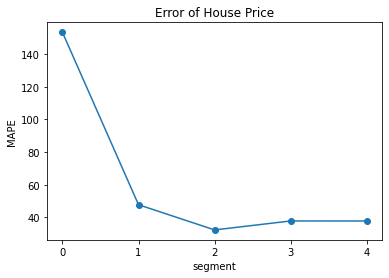

In [ ]:
# plot the error for each price range
segment_1 = answer['Error'][answer['MinSalePrice']<=3000000].mean()
segment_2 = answer['Error'][answer['MinSalePrice']>3000000][answer['MinSalePrice']<=6000000].mean()
segment_3 = answer['Error'][answer['MinSalePrice']>6000000][answer['MinSalePrice']<=10000000].mean()
segment_4 = answer['Error'][answer['MinSalePrice']>10000000][answer['MinSalePrice']<=20000000].mean()
segment_5 = answer['Error'][answer['MinSalePrice']>20000000].mean()
lis = [segment_1, segment_2, segment_3, segment_4,segment_5]
plt.plot(lis,marker = 'o')
plt.xticks([0,1,2,3,4])
plt.title('Error of House Price')
plt.ylabel('MAPE')
plt.xlabel('segment')

There seems to be large error at the smallest price range.

# Part 2 Utilizing images

In this part we will learn how to incorporate unstructure data (images) to our original model.

We are going to train deep learning models which are known to do very well for images. We will use the deep learning models to extract good image features and then concatenate the features to the original features we used in part 1.

To train the deep learning model, we will create a simple binary classifier, which classify whether an image is from an expensive house (higher than 7 million) or a cheap house (lower than 4 million).

In [ ]:
import os
import cv2
import numpy as np
from collections import deque

**Read image files**

We normalize the images and create a matrix contain all of the images.

In [ ]:
#read files
train =  np.zeros((5000,224, 224, 3),dtype=np.float32)
label = []
n=0
a= 0

lisid = []
for root ,dirs,files in os.walk("./image/") :
     
     for i in files:
        
        if i.endswith('.jpg'):
            
            try:
                label.append(data.loc[data['ListingID']==int(i[:-4])]['MinSalePrice'].values[0])
                lisid.append(int(i[:-4]))
                inputImage = cv2.imread("./image/"+i)
                inputImage =inputImage/255.
                train[n] = inputImage
                n=n+1
                
            except:
                a=0
        if(n%200==0):
            #break
            print(n)

0
200
200
400
600
800
800
1000
1200
1200
1400
1600
1600
1800
2000
2000
2000
2000
2200
2400
2600
2800
3000
3000
3200
3200
3400
3400


**Show some example images**

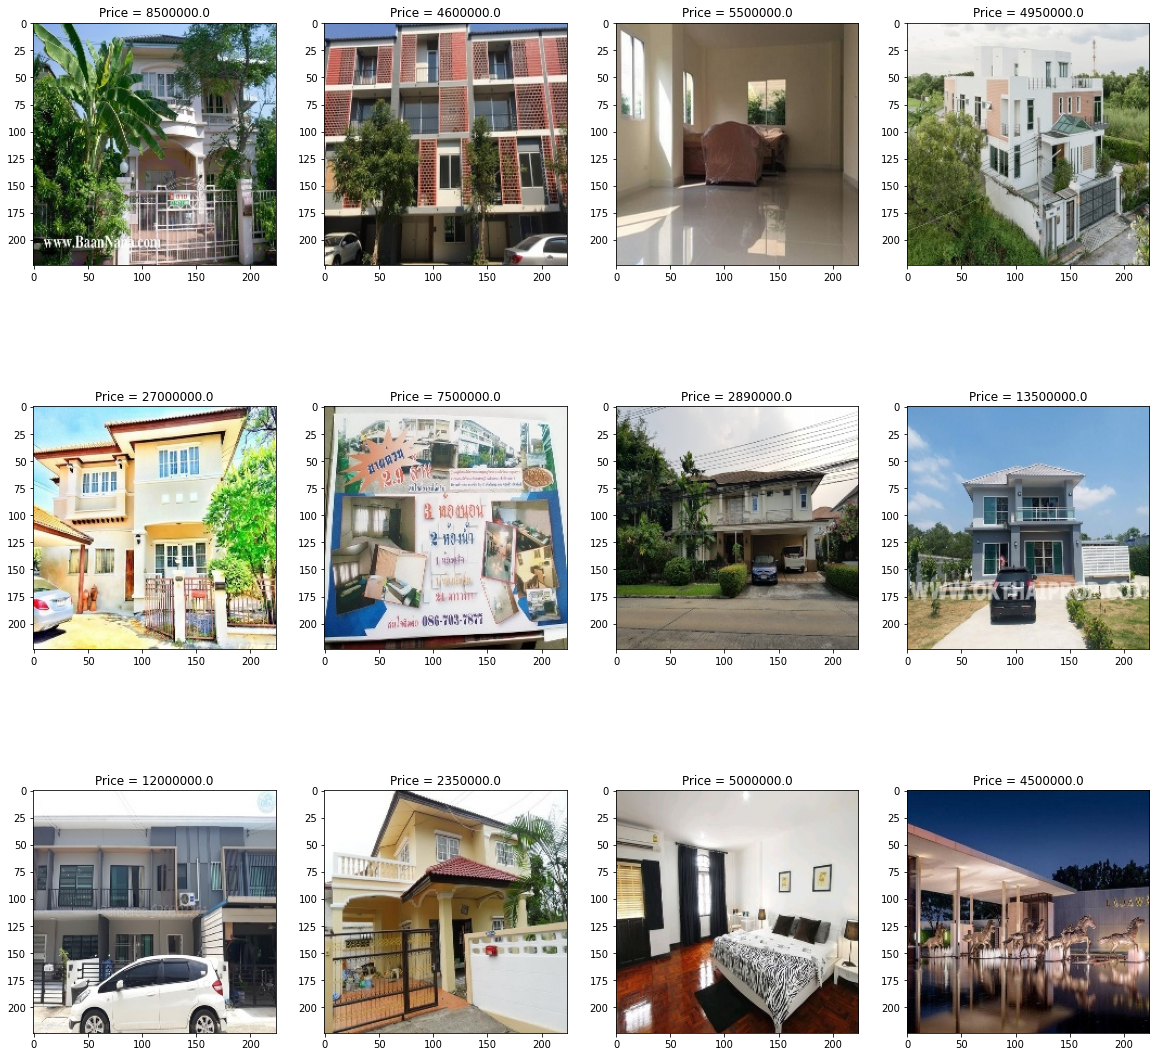

In [ ]:
example_image = []
lisid2 = []
label2 = []
for root ,dirs,files in os.walk("./image/") :    
     for i in files:
        if i.endswith('.jpg'):
            n=n+1
            try:
                label2.append(data.loc[data['ListingID']==int(i[:-4])]['MinSalePrice'].values[0])
                lisid2.append(int(i[:-4]))
                inputImage = cv2.imread("./image/"+i)
                example_image.append(inputImage)
            except:
                a=0
        if(n==12):
            break          
w=10
h=10
fig=plt.figure(figsize=(20, 20))
columns = 4
rows = 3
ax = []
for i in range(columns*rows):
    img = np.random.randint(10, size=(h,w))
    ax.append(fig.add_subplot(rows, columns, i+1) )
    ax[-1].set_title("Price = "+str(label2[i]))  # set title
    plt.imshow(cv2.cvtColor(example_image[i+1], cv2.COLOR_BGR2RGB))
plt.show()

**Seperate the data into two classes**

class1: price<=4000000

class2: price>7000000

We will discard the middle price range.

In [ ]:
l = []
label_class = []
train_2class = []
n=0
for i in range(len(label)):

    if(label[i]<=4000000):
        label_class.append('L')
        l.append(label[i])
        train_2class.append(train[i])
        n=n+1
        
    elif(label[i]>7000000 ):
        label_class.append('H')
        l.append(label[i])
        train_2class.append(train[i])
             

We chose this data split to get roughly equal number of example per class as shown below.

In [ ]:
n/len(label_class)

0.47502903600464574

In [ ]:
from keras.models import Sequential, Model, load_model
from keras import applications
from keras import optimizers
from keras.layers import Dropout, Flatten, Dense
import keras
from sklearn.metrics import accuracy_score
img_rows, img_cols, img_channel = 224, 224, 3
from keras.applications.resnet50 import ResNet50

Using TensorFlow backend.


# Create VGG16 Model

We will use VGG16 as the base model for classification.

In [ ]:
base_model = applications.VGG16(include_top=True, input_shape=(img_rows, img_cols, img_channel))


553467904/553467096 [==============================] - 6s 0us/step


In [ ]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     



---

To use VGG, we will replace the top layers with our layers so that it can handle binary classifcation.

In [ ]:
no_feature = 5

base_model.layers.pop()
out = Dense(no_feature,activation = 'linear')(base_model.layers[-1].output)
outsoftmax = Dense(2,activation = 'softmax')(out)
model2 = Model(base_model.input,outsoftmax)
model2.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [ ]:
model2.compile(loss="binary_crossentropy", optimizer=optimizers.SGD(lr=1e-4,decay=0.1), metrics=['accuracy'])

**Setup the data for model training**

In [ ]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
# encode class values as integers
encoder = LabelEncoder()
encoder.fit(label_class)
encoded_Y = encoder.transform(label_class)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y = np_utils.to_categorical(encoded_Y)

#x = train_2class
y = dummy_y
train_2class = np.array(train_2class,dtype=np.float32)
#y = np.array(y).reshape(3746,1)

**Split image training data**

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(train_2class, y, test_size=0.25, random_state=442)

**Training data augmentation using ImageDataGenerator**

ImageDataGenerator can be used to perform on-the-fly data augmentation, so that we don't have to keep around additional images.

We use ImageDataGenerator to create more sample images by flipping, rotating and shifting.
 

In [ ]:
# train data
# ImageDataGenerator is augmentation of image 
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from keras.callbacks import TensorBoard
batch_size = 64
epochs = 10



train_datagen = ImageDataGenerator(
        rotation_range=30, 
        width_shift_range=0.1,
        height_shift_range=0.1, 
        horizontal_flip=True,
        )

train_datagen.fit(x_train)


history = model2.fit_generator(
    train_datagen.flow(x_train, y_train, batch_size=batch_size),
    steps_per_epoch=x_train.shape[0] // batch_size,
    epochs=epochs,
    validation_data=(x_test, y_test),
    #callbacks=[ModelCheckpoint('vgg_nofreeze.h5', monitor='val_acc', save_best_only=True),tbCallBack]
)

Epoch 1/10
30/30 [==============================] - 26s 865ms/step - loss: 0.7600 - accuracy: 0.4976 - val_loss: 0.7177 - val_accuracy: 0.4954
Epoch 2/10
30/30 [==============================] - 20s 656ms/step - loss: 0.6959 - accuracy: 0.5141 - val_loss: 0.6964 - val_accuracy: 0.5108
Epoch 3/10
30/30 [==============================] - 19s 638ms/step - loss: 0.6812 - accuracy: 0.5793 - val_loss: 0.6992 - val_accuracy: 0.5201
Epoch 4/10
30/30 [==============================] - 19s 647ms/step - loss: 0.6843 - accuracy: 0.5630 - val_loss: 0.6978 - val_accuracy: 0.5310
Epoch 5/10
30/30 [==============================] - 19s 625ms/step - loss: 0.6851 - accuracy: 0.5619 - val_loss: 0.6992 - val_accuracy: 0.5201
Epoch 6/10
30/30 [==============================] - 18s 614ms/step - loss: 0.6804 - accuracy: 0.5665 - val_loss: 0.6946 - val_accuracy: 0.5263
Epoch 7/10
30/30 [==============================] - 18s 613ms/step - loss: 0.6827 - accuracy: 0.5670 - val_loss: 0.6960 - val_accuracy: 0.5294

# TODO#2 Tranfer Learning

**Skip this section until stated. We will return to this section later**

Previously, we train the model using random initialization. One of the power of deep learning is that we can easily transfer knowledge from other tasks to a new task with smaller data. 

This can be done by setting the weights to **imagenet**. The model will then initialize the weights using weights trained on imagenet.

Repeat the training steps like before and look at the performance.

In [ ]:
base_model = applications.VGG16(weights='imagenet', include_top=True, input_shape=(img_rows, img_cols, img_channel))

**Show example predictions**

In [ ]:
# Use the model to predict
y_pred = model2.predict(x_test)
y_pred = (y_pred*2)//1
y_pred

array([[0., 1.],
       [1., 0.],
       [0., 1.],
       ...,
       [0., 1.],
       [1., 0.],
       [1., 0.]], dtype=float32)

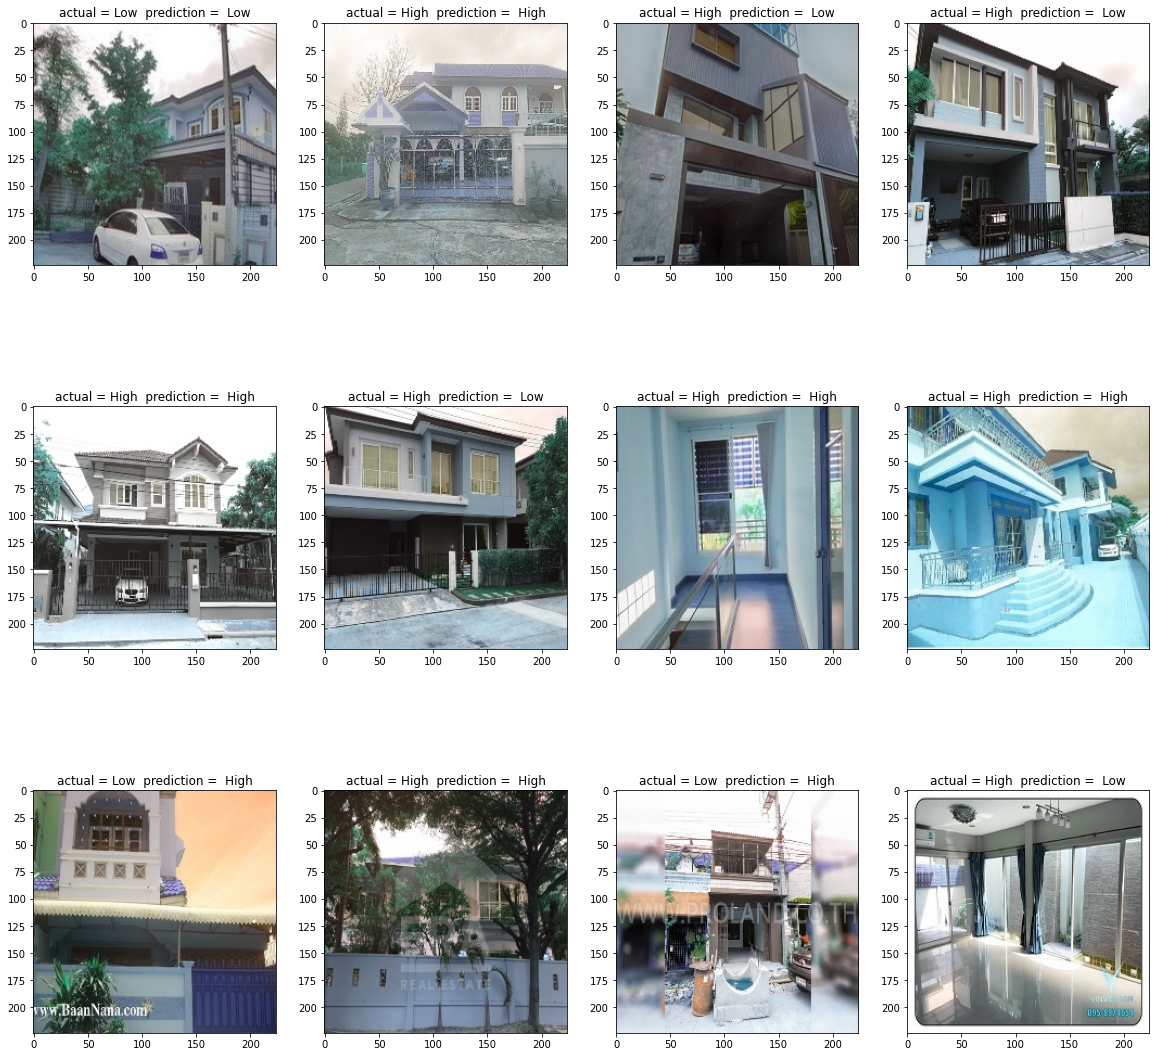

In [ ]:
ax = []
w=10
h=10
fig=plt.figure(figsize=(20, 20))
columns = 4
rows = 3
for i in range(columns*rows):
    img = np.random.randint(10, size=(h,w))
    ax.append(fig.add_subplot(rows, columns, i+1) )
    if(y_pred[i][0]==1):
        ans = 'High'
    else:
        ans = 'Low'
    if(y_test[i][0]==1):
        real = 'High'
    else:
        real = 'Low'    
        
    ax[-1].set_title("actual = "+real+"  prediction =  "+ ans)  # set title
    plt.imshow(x_test[i])
plt.show()

We will use the model to extract features by using the layer with 5 neurons.

This can be done by popping out the classification layer and use the output from (none,5) to extract features.

We will save the model at this stage.

In [ ]:
model2.layers.pop()
model2.summary()

model2.save_weights('weight_hackathon.h5')

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


**create a new model to predict features (extract features)**

In [ ]:
vgg_model = applications.VGG16(weights='imagenet', include_top=True, input_shape=(img_rows, img_cols, img_channel))

vgg_model.layers.pop()
vgg_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

**Add layer of features**

In [ ]:
out = Dense(5,activation = 'linear')(vgg_model.layers[-1].output)
model2 = Model(vgg_model.input,out)
model2.summary()


Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

**Load weight of the trained model**

In [ ]:
model2.load_weights('weight_hackathon.h5')

**Read file image (testset)**

In [ ]:
#read file image
#normalize image by devide 255
#create train data set by append each image in list
#create Salesprice of each house in form of list (label)

test = []
label2 = []
n=0
a= 0
lisid2 = []
for root ,dirs,files in os.walk("./image/") :
     
     for i in files:
        
        if i.endswith('.jpg'):
            n=n+1
            try:
                label2.append(data.loc[data['ListingID']==int(i[:-4])]['MinSalePrice'].values[0])
                
                
                
            except:
                inputImage = cv2.imread("./image/"+i)
                
                inputImage =inputImage/255.
                test.append(inputImage)
                lisid2.append(int(i[:-4]))
                a=a+1
        if(n%200==0):
            #break
            print(n)

200
400
600
800
1000
1200
1400
1600
1800
2000
2200
2400
2600
2800
3000
3200
3400
3600
3800
4000
4200
4400
4600


In [ ]:
len(test)

1186

# **Create data with features from images**

This part involves using the deep learning models to extract image features. We will start with the test set.

In [ ]:
test = np.array(test,dtype=np.float32)
#predict features
y_pred = model2.predict(test)
y_pred

array([[-1.9338764 ,  0.14346828,  2.4438226 , -0.7229708 ,  0.2939036 ],
       [-1.5455836 ,  0.44931462,  2.8828127 , -0.95949465,  0.25576812],
       [-1.779595  ,  0.32576632,  2.574691  , -0.8892177 ,  0.30600178],
       ...,
       [-1.4978861 ,  0.38580403,  2.8150043 , -0.7735421 ,  0.28135872],
       [-1.6536534 ,  0.34958258,  2.7853835 , -0.8477268 ,  0.35291052],
       [-1.9020598 ,  0.3339629 ,  2.420753  , -0.88579994,  0.25602436]],
      dtype=float32)

**create dataframe of features**

In [ ]:
feature = pd.DataFrame({'ListingID':lisid2[:],'f1':y_pred[:,0],'f2':y_pred[:,1],'f3':y_pred[:,2],'f4':y_pred[:,3]
                       ,'f5':y_pred[:,4]})
feature.head(10)

,ListingID,f1,f2,f3,f4,f5
0,100100057,-1.933876,0.143468,2.443823,-0.722971,0.293904
1,110049417,-1.545584,0.449315,2.882813,-0.959495,0.255768
2,110028169,-1.779595,0.325766,2.574691,-0.889218,0.306002
3,100100060,-1.564332,0.623757,2.684572,-1.013397,0.447723
4,110049268,-1.450160,0.408104,2.728539,-0.858425,0.281224
5,110044010,-1.675197,0.488398,2.550165,-0.967747,0.278800
6,110005312,-1.700501,0.361906,2.655219,-0.895074,0.272739
7,100401540,-1.679796,0.485418,2.864674,-1.168512,0.625067
8,110025008,-1.896333,0.377441,2.369358,-0.783487,0.369448
9,110012977,-1.597302,0.490052,2.504584,-0.893963,0.324345


In [ ]:
datatest  = pd.read_csv('./Testset_Homedottech_Hackathon.csv', encoding='utf8')
datatest.head(10)

,ListingID,ListingInfoID,ListingTypeID,BuildingNameTH,MaxRentPrice,MinRentPrice,MaxSalePrice,MinSalePrice,Beds,Baths,Maid,ParkingLots,Size,LotSize,ProjectID,ProjectNameTH,ProjectNameEN,PropertyType,PropertyTypeID,Lat,Lng,Number,CountryID,ProvinceID,DistrictID,SubDistrictID,ZipCode,CreateDate,DistrictNameTH,DistrictNameEN,SubDistrictNameTH,SubDistrictNameEN,ProvinceNameTH,ProvinceNameEN,CountryNameEN,Image
0,100100048,1001000481,1,NaN,NaN,NaN,1750000.0,1750000.0,3,2,0,0,0.0,24.0,NaN,NaN,NaN,TH,3,13.860474,100.710235,100100048,220,1,3.0,8.0,10510.0,2015-06-01 00:00:00,คลองสามวา,Khlong Sam Wa,ทรายกองดิน,Sai Kong Din,กรุงเทพ,Bangkok,Thailand,1.0
1,110004914,1100004831,1,NaN,NaN,NaN,2300000.0,2300000.0,3,2,0,1,116.0,18.0,NaN,NaN,NaN,TH,3,13.699999,100.400107,NaN,220,1,20.0,66.0,10160.0,2018-02-22 19:01:37,บางแค,Bang Khae,หลักสอง,Lak Song,กรุงเทพ,Bangkok,Thailand,1.0
2,110007601,1100007518,1,NaN,NaN,NaN,3500000.0,3500000.0,6,4,0,0,200.0,64.0,NaN,NaN,NaN,TH,3,13.718535,100.748541,60883,220,1,38.0,127.0,10520.0,2018-03-19 09:33:15,ลาดกระบัง,Lat Krabang,ลาดกระบัง,Lat Krabang,กรุงเทพ,Bangkok,Thailand,1.0
3,110001651,1100001572,1,NaN,NaN,NaN,7800000.0,7800000.0,3,3,0,2,194.0,64.0,60011980.0,หมู่บ้านเศรณี รายา 2,Seranee Raya Village 2,HO,1,13.951367,100.572624,NaN,220,1,7.0,23.0,10210.0,2016-09-29 15:14:26,ดอนเมือง,Don Mueang,สีกัน,Si Kan,กรุงเทพ,Bangkok,Thailand,1.0
4,110034202,1100034069,2,NaN,250000.0,250000.0,250000.0,250000.0,20,25,0,0,1280.0,260.0,NaN,NaN,NaN,TH,3,14.039080,100.801809,NaN,220,1,31.0,93.0,10260.0,2018-07-10 11:49:23,พระโขนง,Phra Khanong,บางจาก,Bang Chak,กรุงเทพ,Bangkok,Thailand,NaN
5,101500108,1015001081,1,NaN,NaN,NaN,4900000.0,4900000.0,4,3,0,0,0.0,0.0,NaN,NaN,NaN,TH,3,13.722696,100.503792,N0105,220,1,NaN,NaN,NaN,2015-10-30 00:00:00,NaN,NaN,NaN,NaN,กรุงเทพ,Bangkok,Thailand,NaN
6,110027168,1100027037,1,NaN,NaN,NaN,3250000.0,3250000.0,3,2,0,2,112.0,30.0,60010858.0,ฮาบิทาวน์ - วัชรพล,Habitown - Vacharaphol,TH,3,13.892265,100.639549,NaN,220,1,46.0,143.0,10220.0,2018-06-12 22:22:33,สายไหม,Sai Mai,คลองถนน,Khlong Thanon,กรุงเทพ,Bangkok,Thailand,1.0
7,110006312,1100006229,1,NaN,NaN,NaN,13500000.0,13500000.0,0,0,0,0,0.0,230.0,NaN,NaN,NaN,HO,1,13.795220,100.660846,TE18034,220,1,26.0,79.0,10240.0,2018-03-11 19:09:25,บึงกุ่ม,Bueng Kum,คลองกุ่ม,Khlong Kum,กรุงเทพ,Bangkok,Thailand,NaN
8,100100027,1001000271,1,NaN,NaN,NaN,4300000.0,4300000.0,3,3,0,0,0.0,59.0,NaN,NaN,NaN,HO,1,13.791905,100.711814,100100027,220,1,38.0,123.0,10520.0,2015-06-01 00:00:00,ลาดกระบัง,Lat Krabang,ขุมทอง,Khum Thong,กรุงเทพ,Bangkok,Thailand,1.0
9,110014329,1100014205,1,NaN,30000000.0,30000000.0,30000000.0,30000000.0,4,5,0,0,335.0,75.0,NaN,NaN,NaN,HO,1,13.769830,100.679571,NaN,220,1,43.0,136.0,10240.0,2018-04-26 23:37:57,สะพานสูง,Saphan Sung,สะพานสูง,Saphan Sung,กรุงเทพ,Bangkok,Thailand,1.0


In [ ]:
columns = ['Beds','Baths','Size','LotSize','ListingID','MinSalePrice']
x = pd.DataFrame(datatest, columns=columns)
#y = pd.DataFrame(data, columns=['MinSalePrice'])

**Merge the image features**

In [ ]:
# merge resultdummy and feature
new_x = x.merge(feature, on='ListingID', how='left')
new_x.head(10)


,Beds,Baths,Size,LotSize,ListingID,MinSalePrice,f1,f2,f3,f4,f5
0,3,2,0.0,24.0,100100048,1750000.0,-1.598053,0.560857,3.044549,-0.845644,0.387589
1,3,2,116.0,18.0,110004914,2300000.0,-1.507589,0.167403,2.969172,-0.734313,0.317404
2,6,4,200.0,64.0,110007601,3500000.0,-2.025629,0.444415,2.597839,-0.757858,0.115009
3,3,3,194.0,64.0,110001651,7800000.0,-1.498476,0.379430,2.632706,-0.770404,0.348550
4,20,25,1280.0,260.0,110034202,250000.0,NaN,NaN,NaN,NaN,NaN
5,4,3,0.0,0.0,101500108,4900000.0,NaN,NaN,NaN,NaN,NaN
6,3,2,112.0,30.0,110027168,3250000.0,-1.474513,0.468498,2.727733,-0.835980,0.332979
7,0,0,0.0,230.0,110006312,13500000.0,NaN,NaN,NaN,NaN,NaN
8,3,3,0.0,59.0,100100027,4300000.0,-1.839497,0.550811,2.653260,-0.950679,0.218415
9,4,5,335.0,75.0,110014329,30000000.0,-1.578359,0.196966,3.021544,-1.012934,0.222936


In [ ]:
del new_x['ListingID']
y = new_x['MinSalePrice']

In [ ]:
del new_x['MinSalePrice']
new_x.head(10)

,Beds,Baths,Size,LotSize,f1,f2,f3,f4,f5
0,3,2,0.0,24.0,-1.598053,0.560857,3.044549,-0.845644,0.387589
1,3,2,116.0,18.0,-1.507589,0.167403,2.969172,-0.734313,0.317404
2,6,4,200.0,64.0,-2.025629,0.444415,2.597839,-0.757858,0.115009
3,3,3,194.0,64.0,-1.498476,0.379430,2.632706,-0.770404,0.348550
4,20,25,1280.0,260.0,NaN,NaN,NaN,NaN,NaN
5,4,3,0.0,0.0,NaN,NaN,NaN,NaN,NaN
6,3,2,112.0,30.0,-1.474513,0.468498,2.727733,-0.835980,0.332979
7,0,0,0.0,230.0,NaN,NaN,NaN,NaN,NaN
8,3,3,0.0,59.0,-1.839497,0.550811,2.653260,-0.950679,0.218415
9,4,5,335.0,75.0,-1.578359,0.196966,3.021544,-1.012934,0.222936


**Write datatest with image features file**

In [ ]:
new_x.to_csv('./x_test2_with_featurefromimage.csv', encoding='utf-8',index = False)

**Create trainset with features from image and train the model**

In [ ]:
train = np.array(train[:3515],dtype=np.float32)
#predict features
y_pred = model2.predict(train)
y_pred

array([[-1.439916  ,  0.41110814,  2.8652496 , -0.7847243 ,  0.17474067],
       [-1.8392466 ,  0.379206  ,  2.4102566 , -0.7084109 ,  0.2630634 ],
       [-1.6724018 ,  0.538561  ,  2.345789  , -0.91951567,  0.46320572],
       ...,
       [-1.6995915 ,  0.41826072,  2.753707  , -0.66516286,  0.2666722 ],
       [-1.7171645 ,  0.39939612,  2.6652496 , -0.78144574,  0.3134699 ],
       [-1.4076331 ,  0.3464669 ,  2.9068966 , -0.9870113 ,  0.04558795]],
      dtype=float32)

**create dataframe of features**

In [ ]:

feature = pd.DataFrame({'ListingID':lisid[:],'f1':y_pred[:,0],'f2':y_pred[:,1],'f3':y_pred[:,2],'f4':y_pred[:,3]
                       ,'f5':y_pred[:,4]})
feature.head(10)

,ListingID,f1,f2,f3,f4,f5
0,110047594,-1.439916,0.411108,2.865250,-0.784724,0.174741
1,100800161,-1.839247,0.379206,2.410257,-0.708411,0.263063
2,110048599,-1.672402,0.538561,2.345789,-0.919516,0.463206
3,110054132,-1.744802,0.317388,2.561420,-0.611106,0.541646
4,110048637,-1.745004,0.178902,2.516052,-0.854835,0.142274
5,110009442,-1.388574,0.459494,2.542790,-1.021050,0.207785
6,110016574,-1.731941,0.828508,2.518316,-1.200553,0.551563
7,110004921,-1.814597,0.435944,2.680092,-0.867590,0.315689
8,110012560,-1.828063,0.256379,2.413235,-0.658835,0.153417
9,110027300,-1.507703,0.552323,2.652647,-1.090330,0.284517


In [ ]:
columns = ['Beds','Baths','Size','LotSize','ListingID','MinSalePrice']
x = pd.DataFrame(data, columns=columns)
# merge resultdummy and feature
new_x = x.merge(feature, on='ListingID', how='left')
del new_x['ListingID']
new_y = new_x['MinSalePrice']
del new_x['MinSalePrice']
new_x.head(10)

,Beds,Baths,Size,LotSize,f1,f2,f3,f4,f5
0,4,2,0.0,100.0,-1.642649,0.441963,2.759482,-0.850722,0.409498
1,0,0,0.0,32.0,NaN,NaN,NaN,NaN,NaN
2,3,2,0.0,23.0,-1.723260,0.379374,2.835178,-0.797072,0.235825
3,5,4,588.0,81.0,-1.485267,0.290956,2.568865,-0.897295,0.136130
4,3,3,274.0,0.0,NaN,NaN,NaN,NaN,NaN
5,0,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
6,3,2,212.0,95.2,NaN,NaN,NaN,NaN,NaN
7,3,4,260.0,54.0,-1.281837,0.301790,2.844058,-0.814015,0.305205
8,6,7,0.0,100.0,-1.321771,0.292961,2.836112,-0.904677,0.267428
9,3,2,99.0,0.0,NaN,NaN,NaN,NaN,NaN


In [ ]:
my_model2 = XGBRegressor(n_estimators=200, learning_rate=0.01, max_depth=6)
# my_model.fit(X_train, y_train, early_stopping_rounds=5, 
#               eval_set=[(X_test, y_test)], verbose=False)

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
from sklearn.metrics.scorer import make_scorer

custom_scorer = make_scorer(mean_absolute_percentage_error, greater_is_better=False)
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
cv = ShuffleSplit(n_splits=10, test_size=0.25, random_state=10)

scores = cross_val_score(my_model2, new_x, new_y, cv=cv,scoring=custom_scorer)


[08:32:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:32:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:32:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:32:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:32:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:32:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:32:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:32:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

In [ ]:
print("MAPE: %0.2f (+/- %0.2f)" % (-scores.mean(), scores.std() * 2))

MAPE: 55.09 (+/- 4.84)


**split data**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(new_x, new_y, test_size=0.25, random_state=4452)



In [ ]:
my_model2 = XGBRegressor(n_estimators=100, learning_rate=0.01, max_depth=8)
my_model2.fit(X_train, y_train, early_stopping_rounds=5, 
             eval_set=[(X_test, y_test)], verbose=False)

**read testset file**

In [ ]:
datatest2 =  pd.read_csv('x_test2_with_featurefromimage.csv')

**predict house prices**

In [ ]:
y_pred2 = my_model2.predict(datatest2)
y_pred2


**create submission file**

In [ ]:
submission = pd.DataFrame()
submission['ListingID'] = datatest['ListingID']
submission['MinSalePrice'] = y_pred2
submission.to_csv('./submission.csv', encoding='utf-8',index = False)

# Error analysis

This is a repeat of part 1, where we look at the error for each price range.

In [ ]:
y_pred2 = my_model2.predict(X_test)
y_pred2

In [ ]:
answer = pd.DataFrame()
answer['MinSalePrice'] = y_test
mape = ((abs(answer['MinSalePrice'] - y_pred2))/answer['MinSalePrice'])*100
answer['Prediction'] = y_pred2
answer['Error'] = mape

In [ ]:
segment_1 = answer['Error'][answer['MinSalePrice']<=3000000].mean()
segment_2 = answer['Error'][answer['MinSalePrice']>3000000][answer['MinSalePrice']<=6000000].mean()
segment_3 = answer['Error'][answer['MinSalePrice']>6000000][answer['MinSalePrice']<=10000000].mean()
segment_4 = answer['Error'][answer['MinSalePrice']>10000000][answer['MinSalePrice']<=20000000].mean()
segment_5 = answer['Error'][answer['MinSalePrice']>20000000].mean()
lis_2 = [segment_1, segment_2, segment_3, segment_4,segment_5]
lis_2

In [ ]:
plt.plot(lis,marker = 'o')
plt.plot(lis_2,marker = 'o')
plt.xticks([0,1,2,3,4])
plt.title('Error of House Price')
plt.ylabel('MAPE')
plt.xlabel('segment')
plt.legend(['non_image', 'image'], loc='upper right')

Now that you have complete this. We have trained a deep learning model to extract features from iamges and use it for another task. We can also use transfer learning to help improve this. Go back to **TODO#2 Tranfer Learning** and train another deep learning model with pre-trained weights. Then, repeat all the previous steps to get the pricing predictions.
